Reference: https://github.com/twitterdev/do_more_with_twitter_data/blob/master/examples/timeseries/timeseries.ipynb

In [1]:
import datetime
import functools
import itertools
from pathlib import Path
import timeit
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from utils import *
from topic_utils import *

In [2]:
%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

In [3]:
counts = ['like_count',
         'quote_count',
         'reply_count',
         'retweet_count',
         ]
plot_stats = ['mean',
             'std',
             ]
stats = ['mean',
         'std',
         'min',
         'max',
        ]

# Timeseries

In [4]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [5]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

In [6]:
campaign_start = min(campaign['tweet_time'])
campaign_end = max(campaign['tweet_time'])
campaign_period = campaign_end - campaign_start

print(campaign_start)
print(campaign_end)
print(campaign_period)

2009-09-06 13:56:00
2020-12-27 18:08:00
4130 days 04:12:00


In [7]:
campaign_years = campaign_period / np.timedelta64(1, "Y")
campaign_years

11.30803507258876

In [8]:
def resample_ts(df, freq):
    return (df
             .set_index('tweet_time')
             .resample(freq)
             .size()
             .reset_index()
             .rename(columns={0:'per_{}_count'.format(freq)})
             .set_index('tweet_time')
            )

<IPython.core.display.Javascript object>


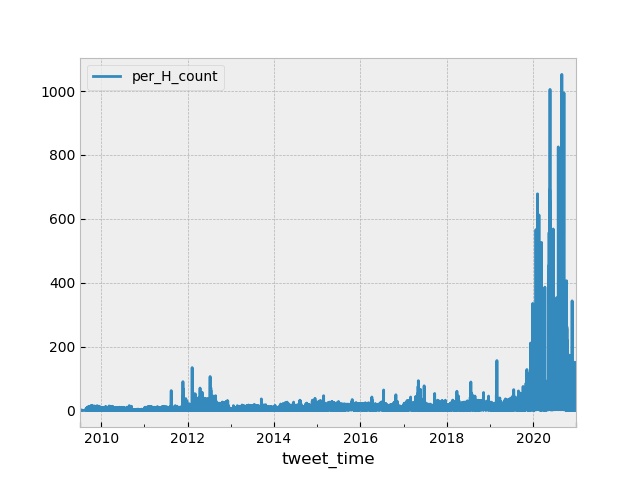

In [9]:
hourly = resample_ts(df, 'H')
hourly.plot()

<IPython.core.display.Javascript object>


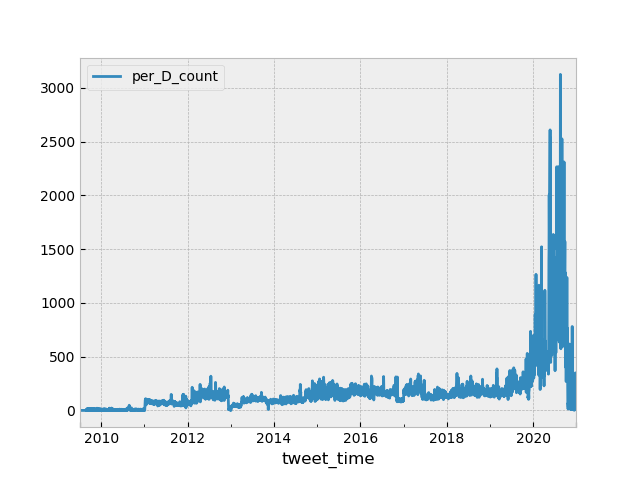

In [10]:
daily = resample_ts(df, 'D')
daily.plot()

In [11]:
print('hourly tweets:\n{}'.format(hourly
                                 .describe().loc[stats]
                                 .astype('int')
                                )
     )

hourly tweets:
      per_H_count
mean            7
std            17
min             0
max          1052


<IPython.core.display.Javascript object>


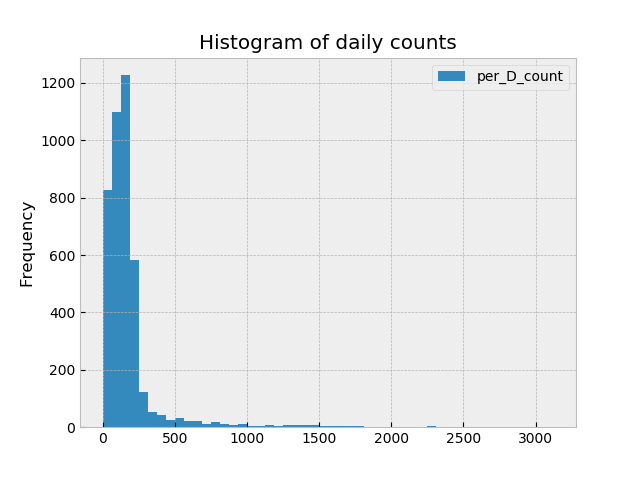

In [12]:
(daily
 .plot.hist(bins=50, title="Histogram of daily counts")
)

In [13]:
top_days = (daily
 .sort_values(by='per_D_count', ascending=False)
 .query('per_D_count > 250')
 .sort_index()
)
len(top_days)

456

<IPython.core.display.Javascript object>


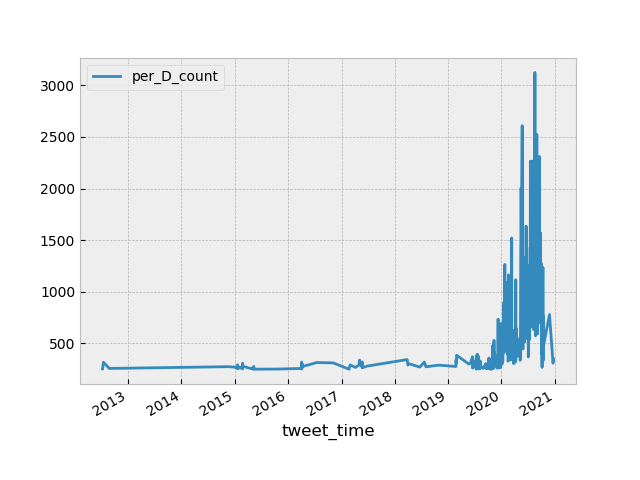

In [14]:
top_days.plot()

## Differencing

We can use simple differencing to get a sense of the change in tweet volume from day to day during the measured time period. This provides a measure of the variability in activity during parts of the campaign.

In [15]:
daily_diff = (daily
             .diff()
             )
daily_std_diff = (daily
             .pipe(standardize)
             .diff()
            )

In [16]:
print(daily_diff
      .describe()
      .loc[['mean','std','min','max']]
)
print('\nstandardized:\n',
        daily_std_diff
         .describe()
         .loc[['min','max']]
)

      per_D_count
mean         0.01
std        117.46
min      -1980.00
max       1836.00

standardized:
      per_D_count
min        -8.33
max         7.72


<IPython.core.display.Javascript object>


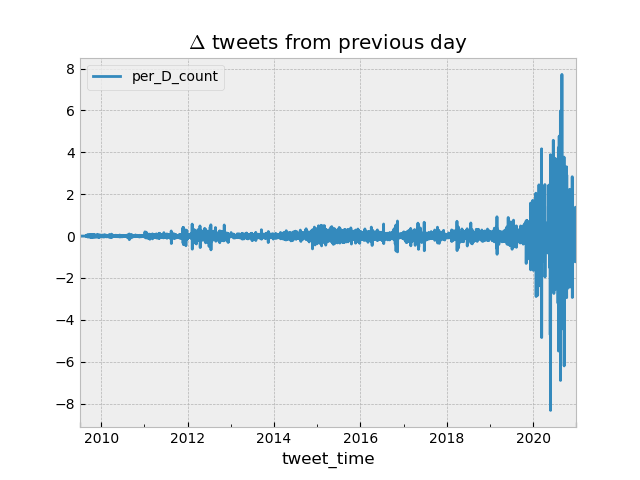

In [17]:
daily_std_diff.plot(title="$\Delta$ tweets from previous day")

In [18]:
hourly_diff = (hourly
              .diff()
              )

hourly_std_diff = (hourly
                     .pipe(standardize)
                     .diff()
                    )

<IPython.core.display.Javascript object>


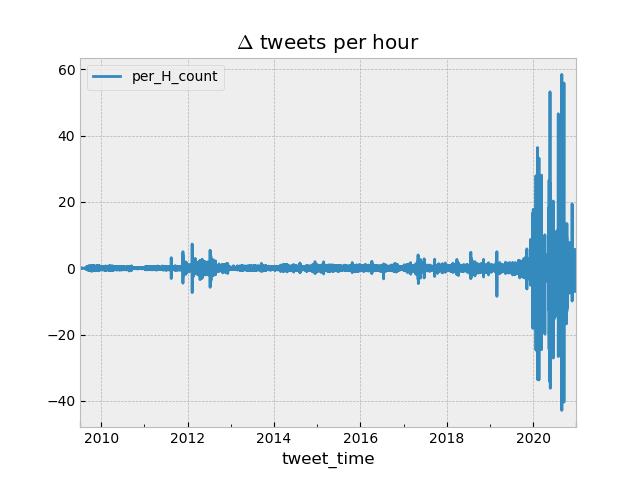

In [19]:
hourly_std_diff.plot(title="$\Delta$ tweets per hour")

<IPython.core.display.Javascript object>


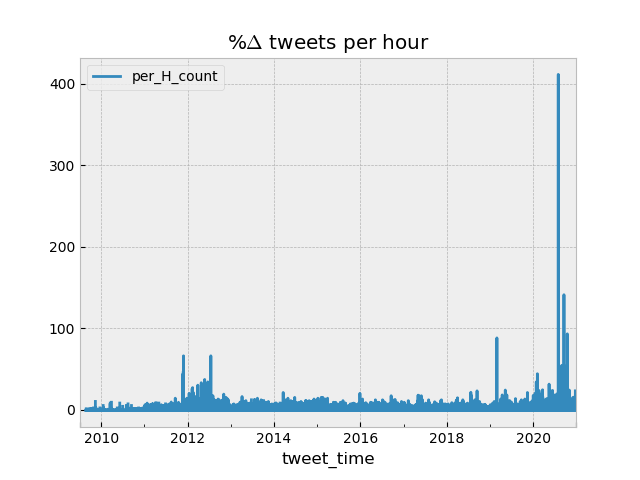

In [20]:
(hourly
 .pct_change()
).plot(title="%$\Delta$ tweets per hour")

## Rolling statistics

Rolling statistics can be used to smooth out the signal and show trends more clearly.

<IPython.core.display.Javascript object>


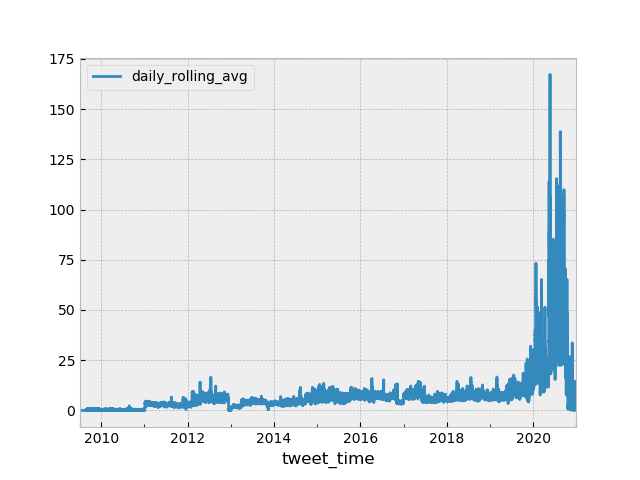

In [21]:
(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count':'daily_rolling_avg',
                  'tweet_time':'time'})
 .fillna(0)
).plot()

<IPython.core.display.Javascript object>


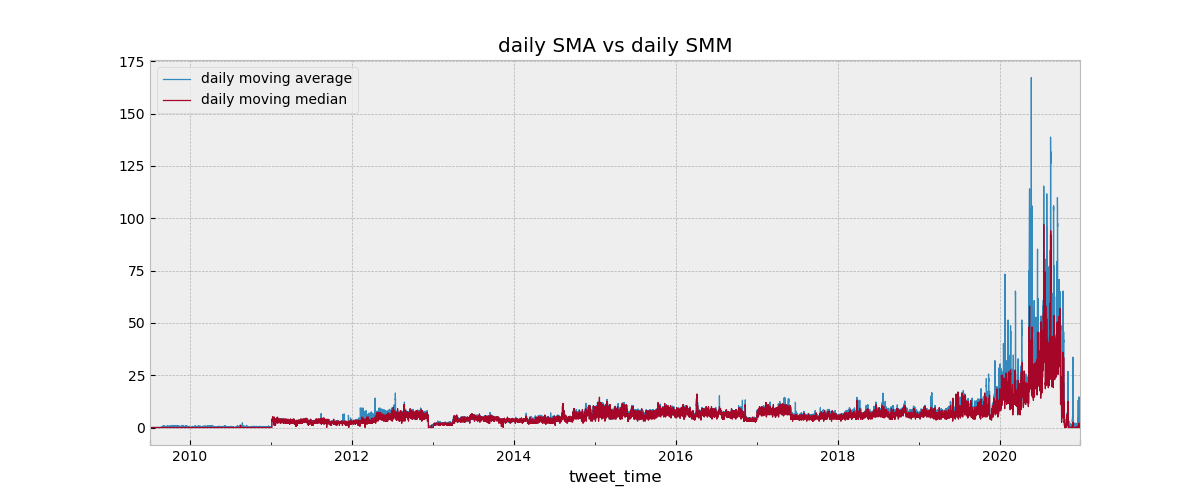

In [22]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .mean()
 .rename(columns={'per_H_count': 'daily moving average'})
 .plot(ax=axes, lw=0.9))

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9))

axes.set_title(label="daily SMA vs daily SMM");

The median is more robust than the mean to outlier values, which also helps us see a smoother signal and more general trend.

<IPython.core.display.Javascript object>


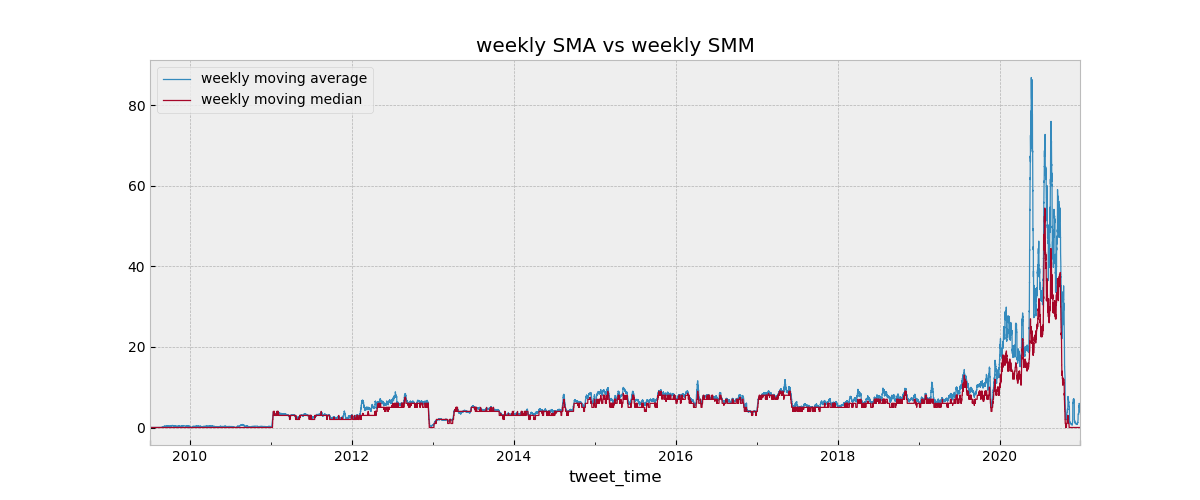

In [23]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24*7)
 .mean()
 .rename(columns={'per_H_count': 'weekly moving average'})
 .plot(ax=axes, lw=0.9));

(hourly
 .rolling(24*7)
 .median()
 .rename(columns={'per_H_count': 'weekly moving median'})
 .plot(ax=axes, lw=0.9));

axes.set_title(label="weekly SMA vs weekly SMM");

Here we observe the difference between time periods used for computing the rolling statistic.

<IPython.core.display.Javascript object>


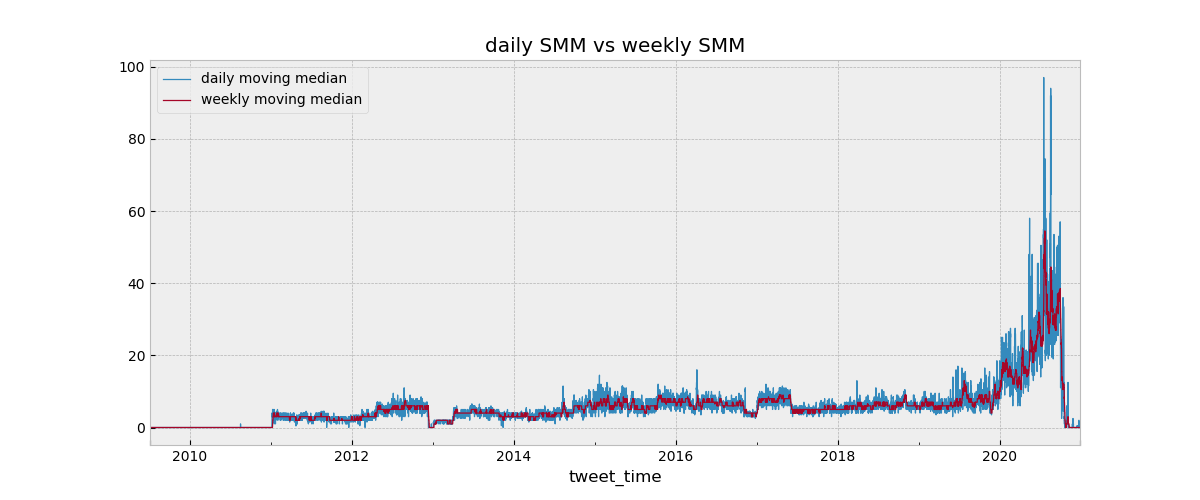

Text(0.5, 1.0, 'daily SMM vs weekly SMM')

In [24]:
fig, axes = plt.subplots(1,1,figsize=(12, 5))

(hourly
 .rolling(24)
 .median()
 .rename(columns={'per_H_count': 'daily moving median'})
 .plot(ax=axes, lw=0.9))

(hourly
 .rolling(24*7)
 .median()
 .rename(columns={'per_H_count': 'weekly moving median'})
 .plot(ax=axes, lw=0.9))

axes.set_title(label="daily SMM vs weekly SMM")

## Time period
These initial views show a clear increase in tweet volume after 2019. Further analysis could for instance compare properties of tweets before 2019 with tweets after 2019. It appears that the campaign was more active in the latter period, so separating the two could show the difference between the active component of the campaign, and the earlier low-volumes activity.

We can also look at high-volume days of the campaign:

In [25]:
(daily
 .dropna()
 .sort_values(by='per_D_count',
              ascending=False)
).head()

,per_D_count
tweet_time,
2020-08-17,3124
2020-05-22,2608
2020-05-25,2533
2020-08-30,2525
2020-09-17,2310


In [62]:
top_day = (daily
             .dropna()
             .sort_values(by='per_D_count',
                          ascending=False)
            )
top_day.idxmax()

per_D_count   2020-08-17
dtype: datetime64[ns]

In [63]:
top_day

,per_D_count
tweet_time,
2020-08-17,3124
2020-05-22,2608
2020-05-25,2533
2020-08-30,2525
2020-09-17,2310
...,...
2010-01-08,0
2010-01-07,0
2010-01-06,0


In [27]:
period = pd.date_range(top_day.iloc[0], periods=24*60*60, freq='s')

In [28]:
day = campaign['tweet_time'].isin(period)
(campaign
 .loc[day]['tweet_text']
)

tweetid
1295178029778366465    We strongly  believe  that what you aimed at i...
1295171150172102656    UAE has encouraged  the Zionist  regime to go ...
1295167588931076099    UAE couldn't  support  the master of terrorism...
1295171990119051264    UAE membuktikan bahwa mereka pengecut dengan b...
1295174953562787849    Imarati should end all its secret and public s...
                                             ...                        
1295155883807145984    Indonesia merdeka harus menjadi tujuan hidup k...
1295155884545302528    Hari kemerdekaan Indonesia adalah 17 Agustus s...
1295344560260952065    El presidente de la Federación Rusa, #Vladimir...
1295464601849602050    watch this !  Miles Taylor endorsing Biden! 
e...
1295463407651557378    Además de la pandemia y el caos político, Bras...
Name: tweet_text, Length: 3061, dtype: string

### Topic modeling for top day

In [70]:
string_agg = lambda x: list(x)

In [118]:
top_days = (campaign
 .reset_index()
 .set_index('tweet_time')
 .resample('D')[['tweetid','tweet_text']]
 .agg({'tweetid':'size','tweet_text':string_agg})
 .sort_values(by='tweetid', ascending=False)
)

In [119]:
top_days

,tweetid,tweet_text
tweet_time,,
2020-08-17,3061,[RT @irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL...
2020-05-22,2559,[Todos los musulmanes y personas libres del mu...
2020-08-30,2493,[#Rusia alerta que los servicios de inteligenc...
2020-05-25,2480,[Un internauta venezolano sugiere que su carro...
2020-09-17,2229,[#China celebra el fallo de la Organización Mu...
...,...,...
2010-05-31,0,[]
2010-06-01,0,[]
2010-06-02,0,[]


In [120]:
user_tweets = (top_days['tweet_text']).iloc[0]
user_tweets

['RT @irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8I=: El presidente de #Rusia ha expresado su disposición a enviar ayuda militar a #Bielorrusia si fuera necesario.\n\nSeguir leyendo…',
 '@safewordthe2nd @Mahyargdrz عه نه! چرا!؟ پس کی ما رو شکست بده و با \u200cفرهنگیشو بزنه تو صورتمون در صورت اعتراض!؟',
 'Una fuente saudí afirma que el príncipe heredero de #ArabiaSaudi pone como condición a EE.UU. para normalizar lazos con #Israel que le asegure su reinado.\n\n#MuhammadBinSalman \n\nhttps://t.co/aBsbnyK0QP',
 'Dirgahayu RI ke 75 \n\nJangan sia-siain jasa pahawan yang udah mati-matian memerdekakan Indonesia yaak\n\n#DirgahayuRI75 #17Agustus1945 #HUT75RI\n#DirgahayuIndonesia75th \n#DirgahayuRepublikIndonesia \n#dirgahayuindonesia https://t.co/FNtBXZMfu1',
 '"Kita berutang kepada Palestina. Palestina yang mengakui kemerdekaan Indonesia pertama kali bahkan sejak tahun 1944," \n\n"We owe it to Palestine. Palestine declared Indonesia\'s independence for the first time since 1944," \n#HUT75RI #H

In [106]:
def extract_topics(documents_list,
                   vectorizer=None,
                   n_samples=2000,
                   n_features=1000,
                   n_components=10,
                   n_top_words=20,
                   apply_preprocessing=True,
                   stop_words=[*stopwords.words(),
                                  '<-url->', '<-@->', '<-#->', 
                                  '...','`',',','-',"'",
                                  '.','^',],
                   ):
    
    vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=[*stopwords.words(),
                                              '<-url->', '<-@->', '<-#->', 
                                              '...','`',',','-',"'"],
                                 ngram_range=(1,2),
                                 tokenizer=TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True).tokenize
                                )
    if apply_preprocessing:
        documents_list = (documents_list
                            .map(long_string)
                            .map(preprocess_string)
                         )

    print('vectorizing...')
    #t1 = default_timer()
    tf = vectorizer.fit_transform(documents_list)
    
    #print('elapsed: {}'.format(default_timer() - t1))
    
    
    print(('LDA:\nn_samples: {}\nn_features: {}\nn_components: {}')
          .format(n_samples, n_features, n_components))

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf)
    
    tf_feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, 
                   tf_feature_names, 
                   n_top_words,
                   n_components,
                   'Categories in LDA model')
    plt.tight_layout()

In [121]:
documents = [preprocess_string(long_string(user_tweets), placeholders=True)]

vectorizing...
LDA:
n_samples: 2000
n_features: 2000
n_components: 6


<IPython.core.display.Javascript object>


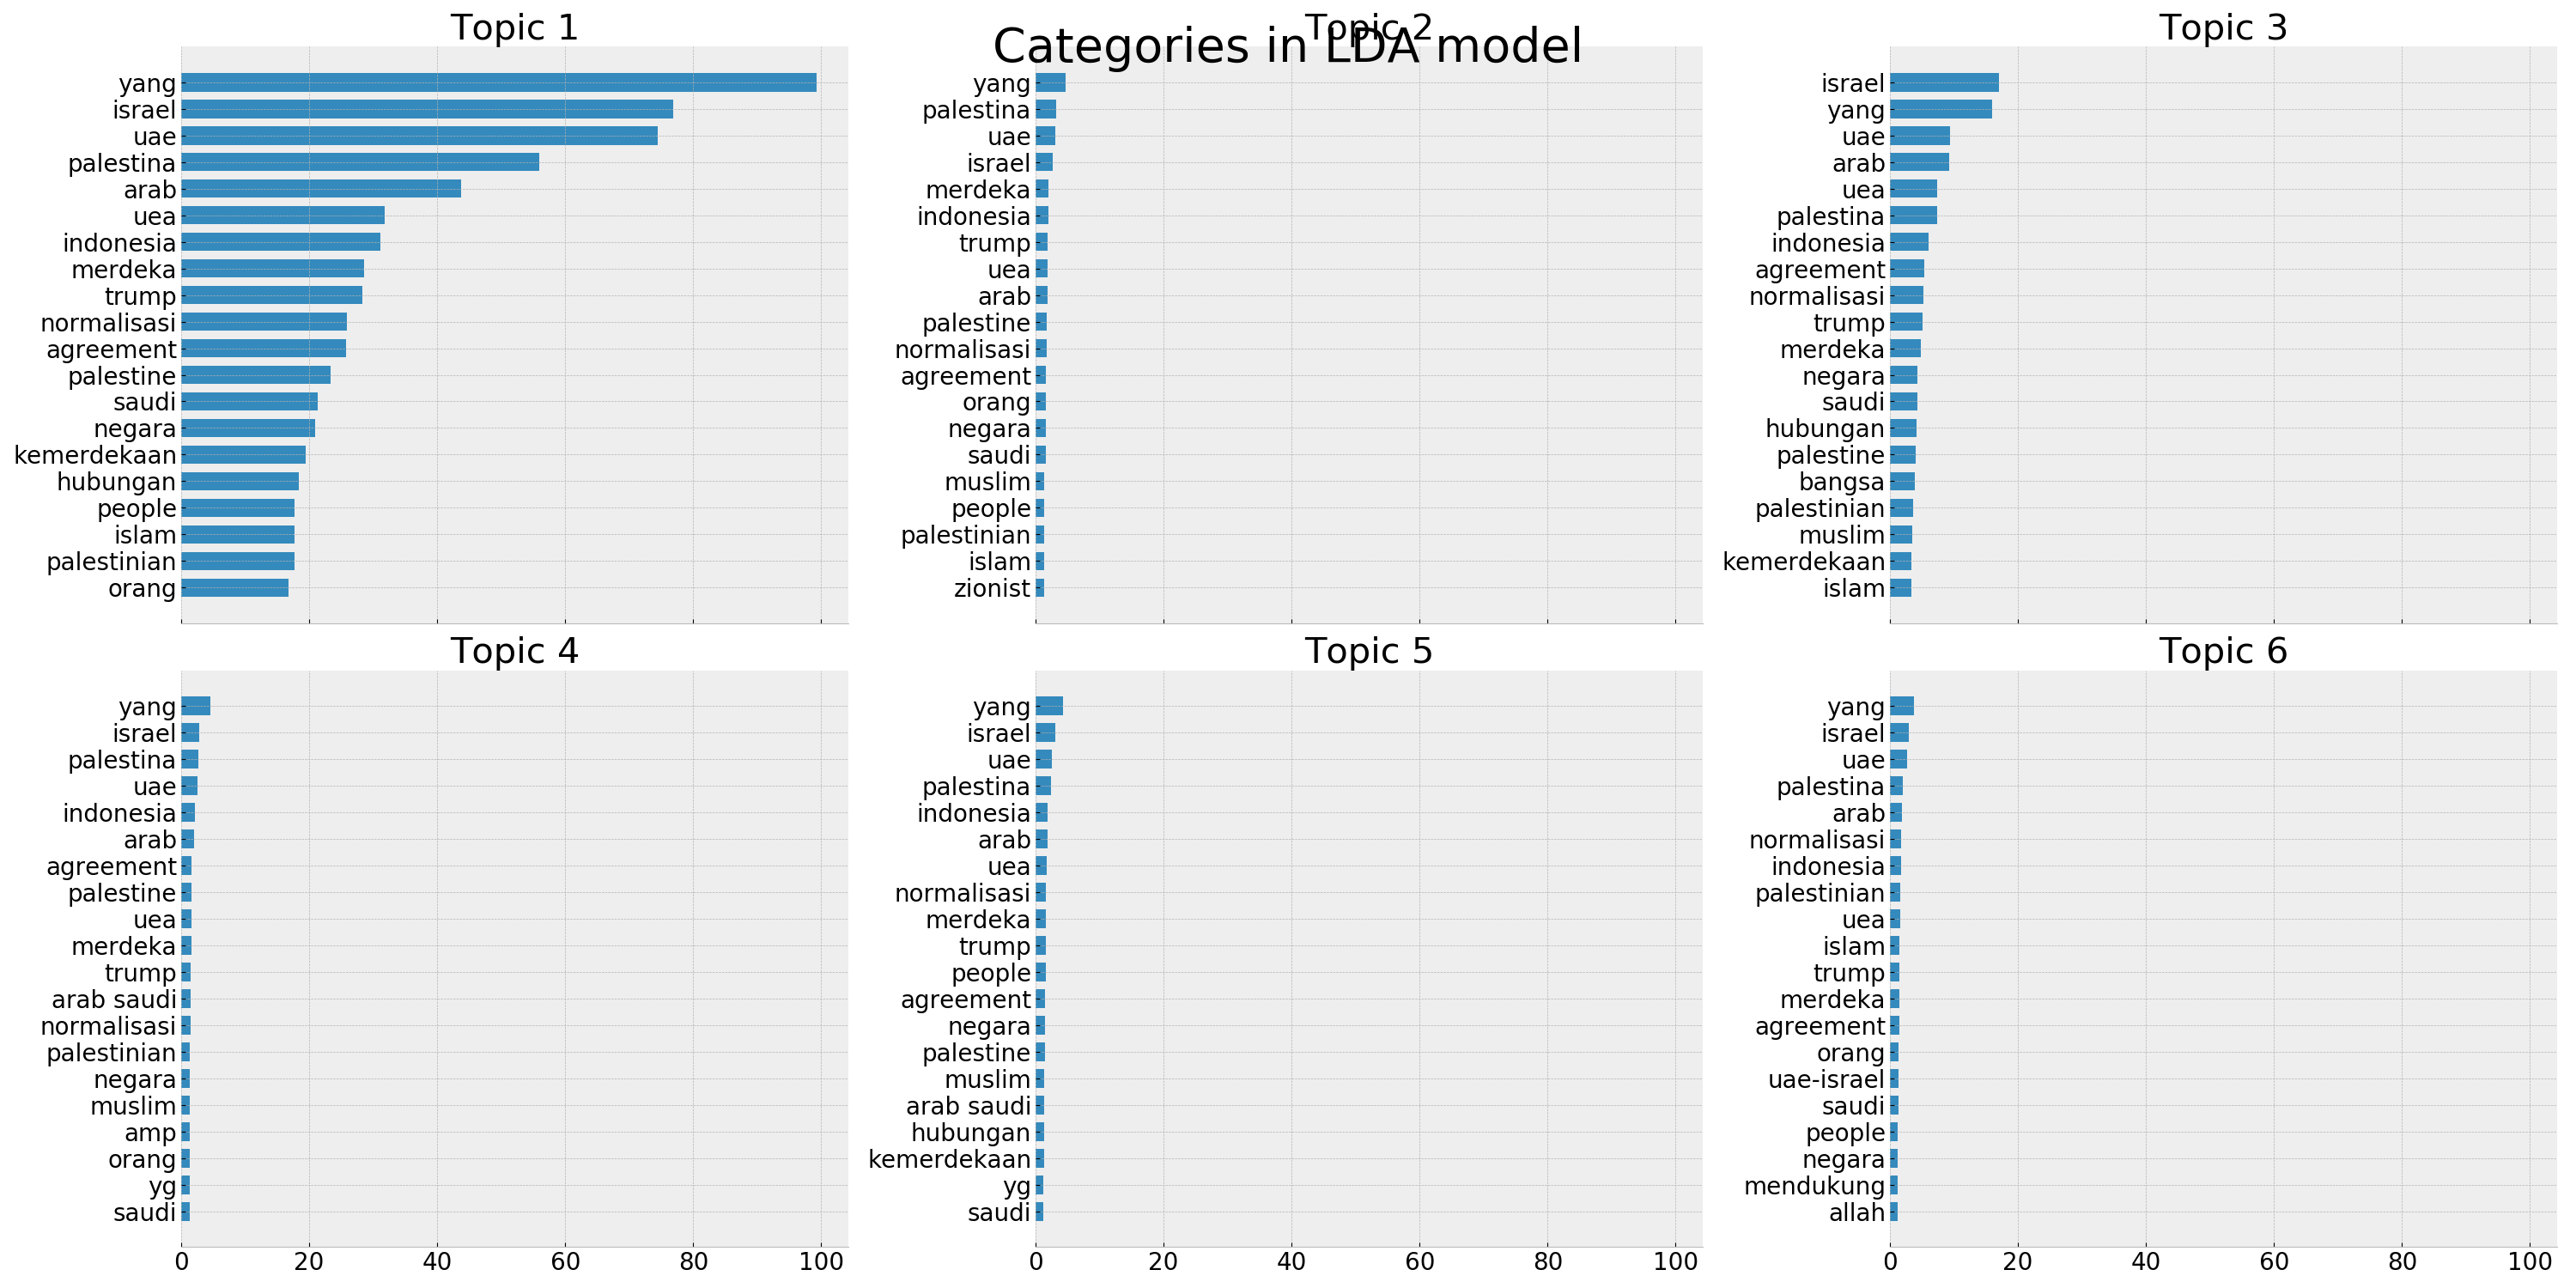

In [124]:
extract_topics(documents,
               apply_preprocessing=False,
               n_features=2000,
               n_components=6)

We see that the top day was the day after Israel's foreign minister made a public declaration about military cooperation with the UAE, and the contents of the tweets are related to this event. Further analysis could potentially include applying sentiment analysis to these tweets and tweets in the surrounding time period to understand the sentiment towards this event, perhaps comparing campaign tweets with general tweets on the topic.